# BioPhenomDetector - Demo

In the following demonstration, you can learn how to use most of the module provided in this package to analyze the vegetative properties of a small area in Ticino national park in northern Italy.

In [1]:
import datetime as dt
from pathlib import Path

import shapely

In [2]:
import preprocessing as pp
import data_loading as data
import anomalies as an
import estimations as em
import visualize as vz

### Configuration

In [3]:
data_path = Path("data")
# Coordinate reference system in which the aoi is given
crs = data.CRS(32632)
# Area of interest (aoi) 
aoi = {'bbox': shapely.box(480605.845, 5018618.755000001, 503395.7250000001, 5047643.354999999).bounds,
       'crs': crs}

In [4]:
time_range = (dt.date(2017, 1, 1), dt.date(2022, 12, 31))

### Load Sentinel-2 data from Copernicushub
Add your Copernicushub credentials here. If you don't have any, you can create a free account [here](http://dataspace.copernicus.eu/) and create your credentials [here](https://shapps.dataspace.copernicus.eu/dashboard/#/account/settings). 

In [5]:
copernicushub_config = data.create_configuration(
    client_id="", 
    client_secret=""
)

In [6]:
images = data.load_satellite_images(config=copernicushub_config,
                                    aoi=aoi, 
                                    time_range=time_range, 
                                    file_path=data_path, 
                                    show_progress=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 425/425 [01:10<00:00,  6.02image/s]


### Compute biophysical properties on a single random Sentinel-2 image

In [7]:
dataset = em.create_dataset(images[10])

In [8]:
lai = em.estimate_lai(dataset)
cwc = em.estimate_cwc(dataset)
ccc = em.estimate_ccc(dataset)

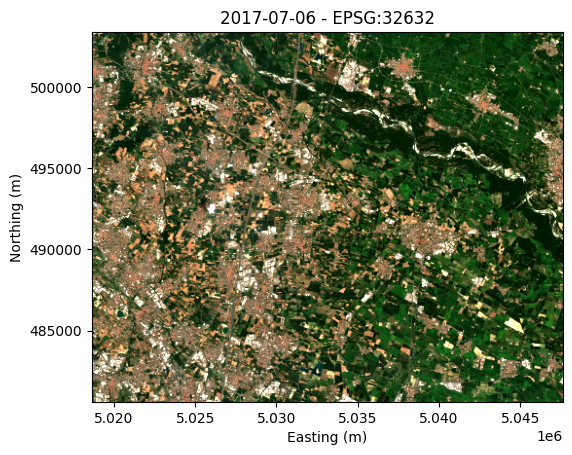

In [9]:
vz.plot_satellite_image(dataset)

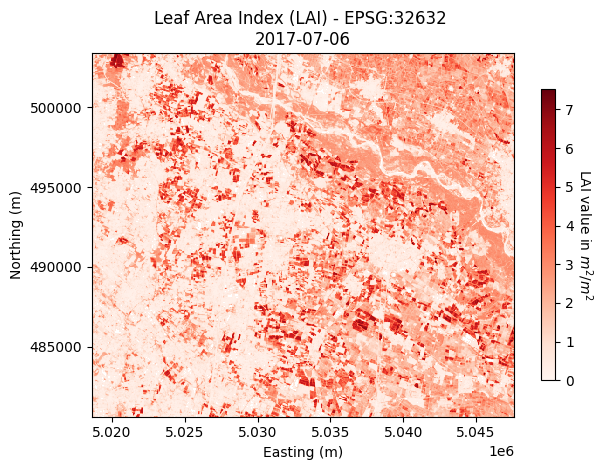

In [10]:
vz.plot_biophys_result(lai, cmap="Reds")

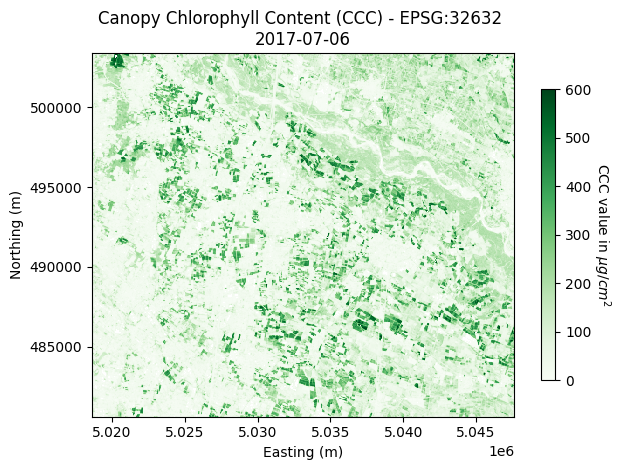

In [11]:
vz.plot_biophys_result(ccc, cmap="Greens")

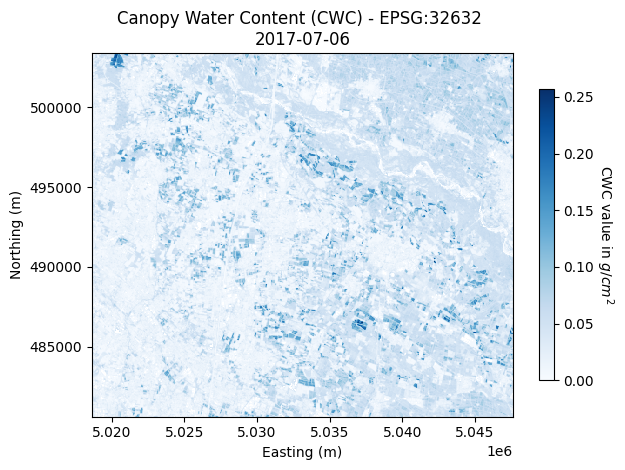

In [12]:
vz.plot_biophys_result(cwc, cmap="Blues", save_as="cwc.jpg")

### To save the resulting image as a geoTiff, you can use the following function:

In [13]:
# data.save_as_tiff(ccc, f"{images[0]['name']}_ccc.tiff")

### Compute anomaly for a specific date

In [14]:
date = dt.date(2022,8,4)

In [15]:
time_series = an.create_time_series(images, em.BiophysicalVariable.CCC)

In [16]:
interpolated = an.fill_gaps_and_smooth_data(time_series)

In [17]:
anomaly = an.compute_sda_for_dayofyear(interpolated, date)

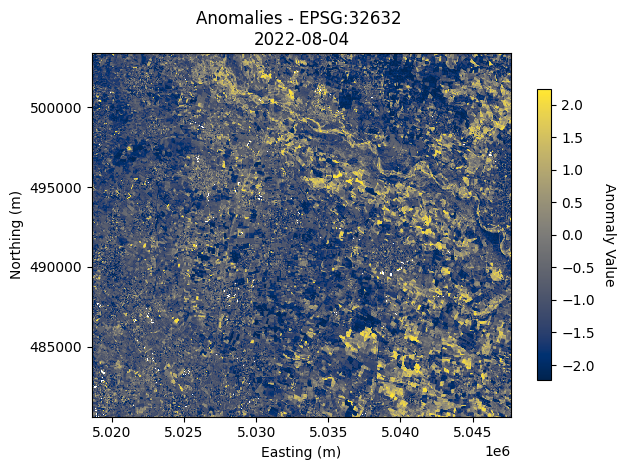

In [18]:
vz.plot_anomalies(anomaly, cmap="cividis")

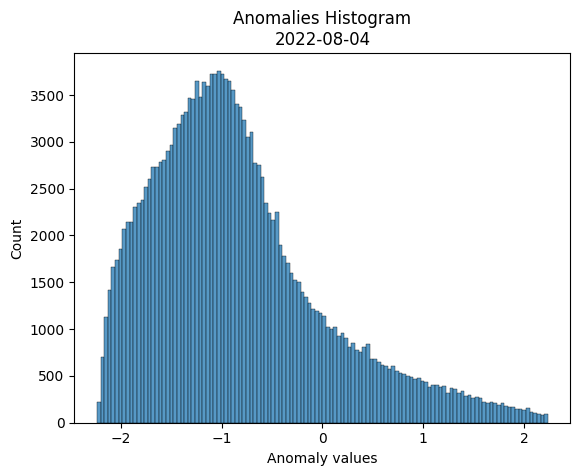

In [19]:
vz.plot_anomaly_hist(anomaly)